<a href="https://colab.research.google.com/github/audreyemmely/computer-vision/blob/main/visaocomp_lista5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Resolução Lista 5**
---

ARQUIMEDES VINÍCIUS PEREIRA DE FRANÇA MOURA

AUDREY EMMELY RODRIGUES VASCONCELOS



## Instalação do opencv

In [ ]:
# !pip install opencv-python==4.5.5.62
# !pip install opencv-contrib-python==4.5.5.62
# !pip install tf-explain

In [ ]:
!git clone https://github.com/ultralytics/yolov5  # clone
%cd yolov5
%pip install -qr requirements.txt  # install

import torch
import utils
display = utils.notebook_init()  # checks

YOLOv5 🚀 v6.1-304-g51fb467 Python-3.7.13 torch-1.11.0+cu102 CPU


Setup complete ✅ (2 CPUs, 12.7 GB RAM, 40.9/107.7 GB disk)


## Importando bibliotecas

In [ ]:
import os
import numpy as np
import pandas as pd
from skimage.feature import hog
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator
from PIL import Image
from numpy import expand_dims
from keras.layers import GlobalAveragePooling2D, Dense
from keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.applications.mobilenet_v2 import MobileNetV2
from sklearn import svm
from sklearn.metrics import classification_report,accuracy_score

## Questão 1

Usando a plataforma Kaggle, pesquise um base supervisionada de imagens que possa ser usada para treinar um classificador binário de imagens. Esta base deve conter exemplos de duas classes. Considere 70% das amostras para treino, e 30% para teste (método holdout).

a) Usando OpenCV, extraia descritores HOG (Histogram of Gradients), e treine um classificador SVM. Exiba a acurácia atingida no conjunto de teste e a matriz de confusão. Exiba exemplos. Obs.: note que essa abordagem é semelhante ao detector Dalal-Triggs, porém aqui estamos usando-a para classificação de imagens.

Link kaggle:

https://www.kaggle.com/datasets/muratkokludataset/grapevine-leaves-image-dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
main_df = pd.DataFrame()

In [ ]:
main_path = '/content/drive/MyDrive/Grapevine_Leaves_Image_Dataset/'
path_Ak = main_path + 'Ak'
path_Buzgulu = main_path + 'Buzgulu'

In [ ]:
main_df['images'] = os.listdir(path_Ak) + os.listdir(path_Buzgulu)

In [ ]:
classes = []
paths = []
for image in main_df['images']:
    class_ = image.split(' (')[0]
    classes.append(class_)
    paths.append(main_path+class_+'/'+image)

In [ ]:
main_df['classes'] = classes
main_df['path'] = paths

In [ ]:
main_df.head()

images classes                                               path
0  Ak (17).png      Ak  /content/drive/MyDrive/Grapevine_Leaves_Image_...
1  Ak (15).png      Ak  /content/drive/MyDrive/Grapevine_Leaves_Image_...
2   Ak (1).png      Ak  /content/drive/MyDrive/Grapevine_Leaves_Image_...
3  Ak (12).png      Ak  /content/drive/MyDrive/Grapevine_Leaves_Image_...
4  Ak (13).png      Ak  /content/drive/MyDrive/Grapevine_Leaves_Image_...

In [ ]:
def hog_images(class_name):
    classes_df = main_df[main_df['classes'] ==  class_name].reset_index(drop = True)
    for idx,i in enumerate(np.random.choice(main_df['path'],4)):
        image = cv2.imread(i)
        fd, hog_image = hog(image, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True, multichannel=True)
        fig = plt.figure(figsize=(8, 8))
        plt.suptitle(class_name)
        plt.subplot(2,2,1)
        plt.imshow(hog_image, cmap="gray")
        plt.show()

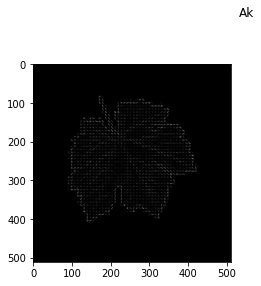

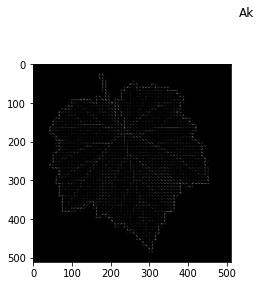

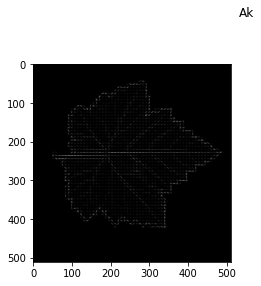

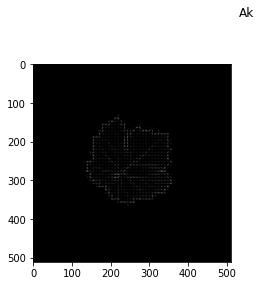

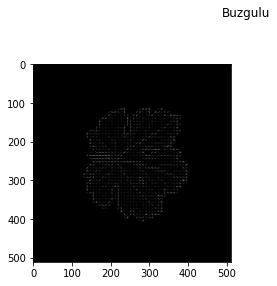

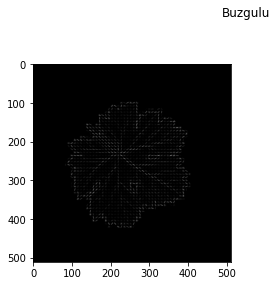

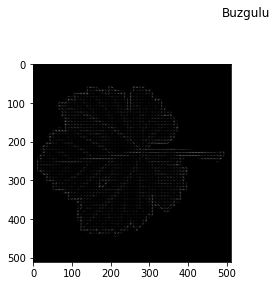

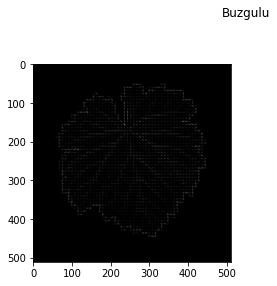

In [ ]:
for class_name in main_df['classes'].unique():
    hog_images(class_name)

b) Agora o objetivo é treinar uma CNN. Usando a abordagem de transferência de aprendizado (transfer learning), realize treinamentos usando modelos VGG16, ResNet50, e MobileNetV2 pré-treinados. Compare os resultados usando acurácias e matrizes de confusão. Exiba exemplos.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(main_df[['path', 'classes']], main_df[['classes']], test_size=0.3, random_state=42)

In [ ]:
def plot_augimages(paths, datagen):
    plt.figure(figsize = (14,28))
    plt.suptitle('Augmented Images')
    
    midx = 0
    for path in paths:
        data = Image.open(path)
        data = data.resize((224,224))
        samples = expand_dims(data, 0)
        it = datagen.flow(samples, batch_size=1)
    
        # Show Original Image
        plt.subplot(10,5, midx+1)
        plt.imshow(data)
        plt.axis('off')
    
        # Show Augmented Images
        for idx, i in enumerate(range(4)):
            midx += 1
            plt.subplot(10,5, midx+1)
            
            batch = it.next()
            image = batch[0].astype('uint8')
            plt.imshow(image)
            plt.axis('off')
        midx += 1
    
    plt.tight_layout()
    plt.show()

#### **VGG16**

In [ ]:
from keras.applications.vgg16 import preprocess_input

In [ ]:
vgg_datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.10,
    brightness_range=[0.6,1.4],
    channel_shift_range=0.7,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest',
    preprocessing_function=preprocess_input
) 

In [ ]:
train_generator_vgg = vgg_datagen.flow_from_dataframe(
        X_train,  # This is the source directory for training images
        x_col='path',
        y_col='classes',
        target_size=(227, 227),  # All images will be resized to 150x150
        batch_size=32,
        class_mode="categorical",
        shuffle=True,
)

Found 140 validated image filenames belonging to 2 classes.


In [ ]:
test_generator_vgg = vgg_datagen.flow_from_dataframe(
        X_test,  # This is the source directory for training images
        x_col='path',
        y_col='classes',
        target_size=(227, 227),  # All images will be resized to 150x150
        batch_size=32,
        class_mode="categorical",
        shuffle=True,
)

Found 60 validated image filenames belonging to 2 classes.


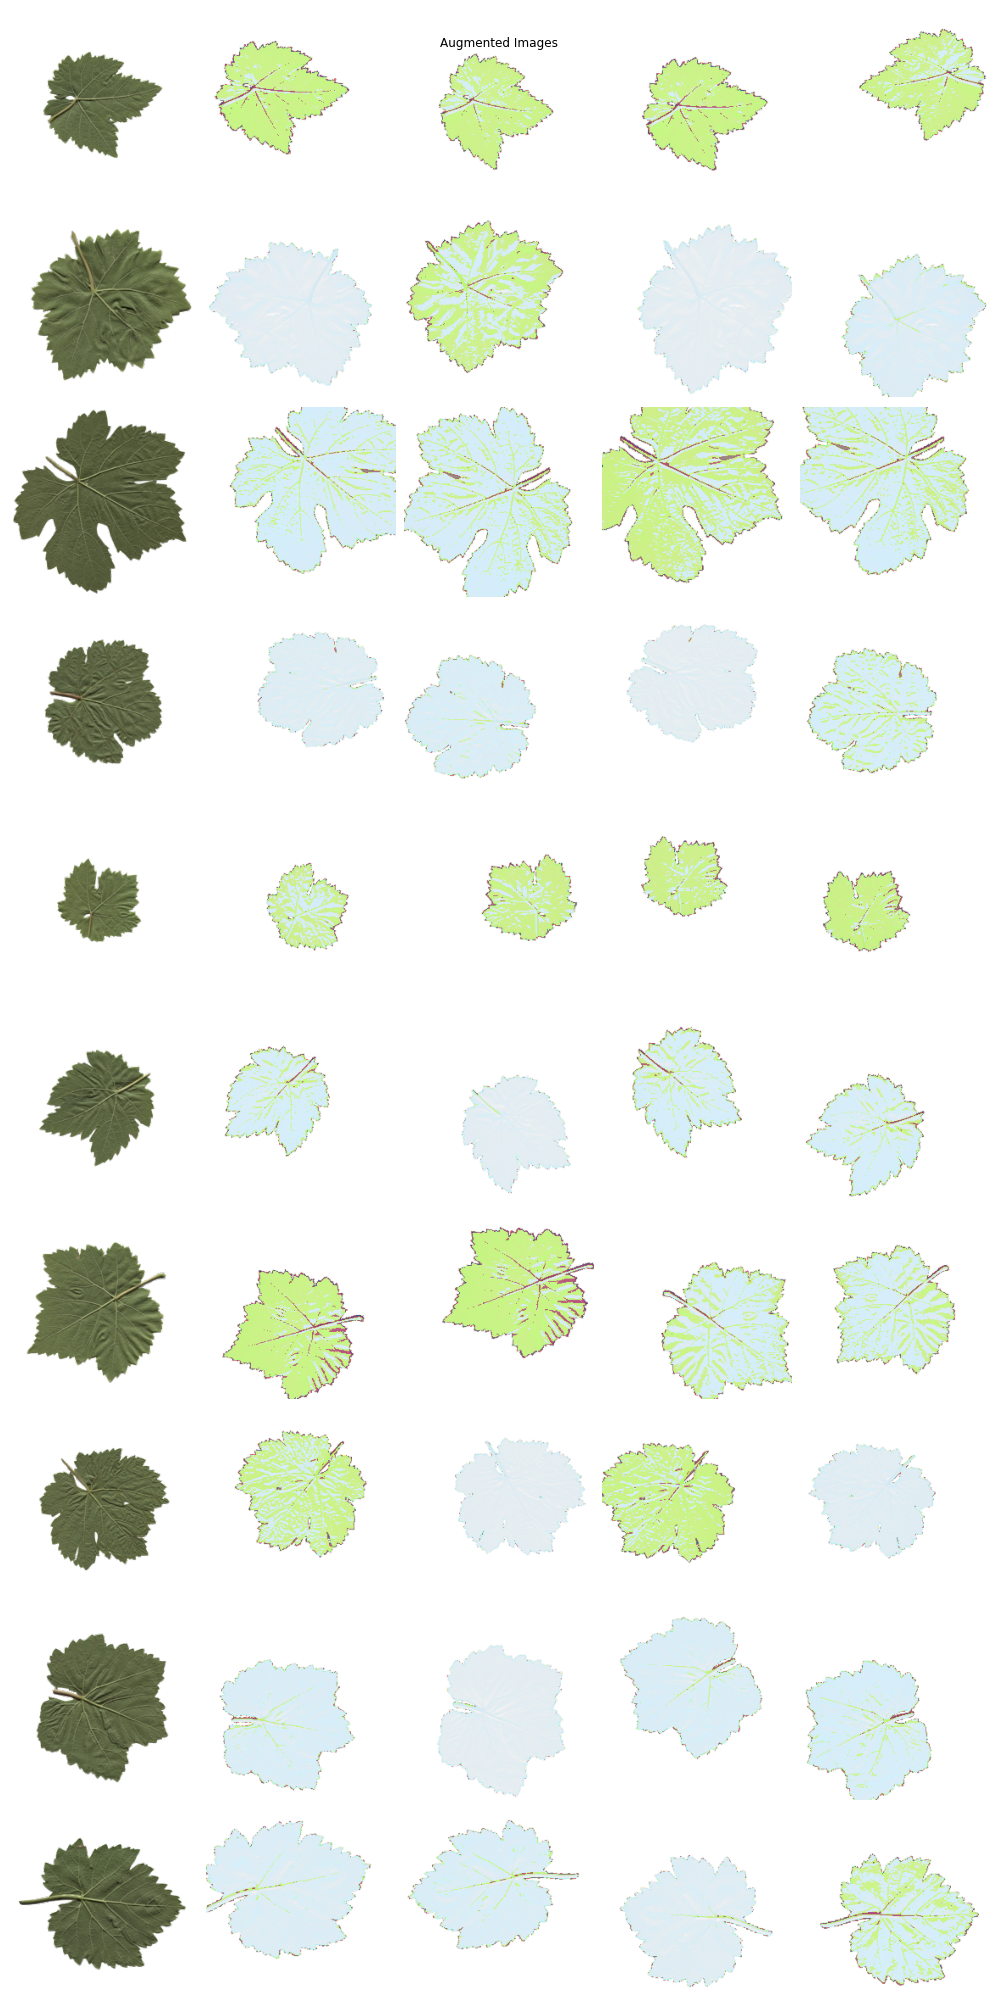

In [ ]:
plot_augimages(np.random.choice(main_df['path'],10), vgg_datagen)

In [ ]:
vgg16 = VGG16(include_top = False, input_shape = (227,227,3), weights = 'imagenet')

# training of all the convolution is set to false
for layer in vgg16.layers:
    layer.trainable = False

x = GlobalAveragePooling2D()(vgg16.output)
predictions = Dense(2, activation='softmax')(x)

model_vgg = Model(inputs = vgg16.input, outputs = predictions)

In [ ]:
model_vgg.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

In [ ]:
history_vgg = model_vgg.fit(
      train_generator_vgg,
      validation_data=test_generator_vgg,
      epochs=20,
      verbose='auto')

Epoch 1/20
5/5 [==============================] - 97s 20s/step - loss: 0.8894 - accuracy: 0.5500 - val_loss: 0.9169 - val_accuracy: 0.4667
Epoch 2/20
5/5 [==============================] - 95s 20s/step - loss: 0.8589 - accuracy: 0.5214 - val_loss: 0.7808 - val_accuracy: 0.6000
Epoch 3/20
5/5 [==============================] - 95s 20s/step - loss: 0.7193 - accuracy: 0.6429 - val_loss: 0.7265 - val_accuracy: 0.5500
Epoch 4/20
5/5 [==============================] - 95s 20s/step - loss: 0.7142 - accuracy: 0.6143 - val_loss: 0.6770 - val_accuracy: 0.6500
Epoch 5/20
5/5 [==============================] - 95s 20s/step - loss: 0.6442 - accuracy: 0.6429 - val_loss: 0.5416 - val_accuracy: 0.7333
Epoch 6/20
5/5 [==============================] - 93s 22s/step - loss: 0.6359 - accuracy: 0.6500 - val_loss: 0.6179 - val_accuracy: 0.6667
Epoch 7/20
5/5 [==============================] - 95s 20s/step - loss: 0.5393 - accuracy: 0.7214 - val_loss: 0.6267 - val_accuracy: 0.6833
Epoch 8/20
5/5 [===========

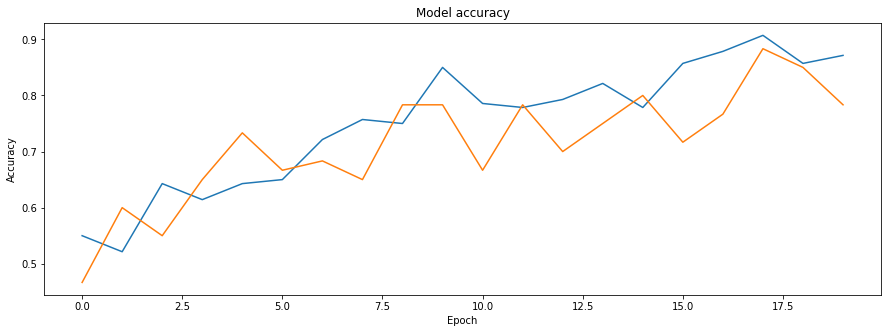

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(history_vgg.history['accuracy'])
plt.plot(history_vgg.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

In [ ]:
predictions = model_vgg.predict(test_generator_vgg)  # Vector of probabilities
pred_labels = np.argmax(predictions, axis = 1)

In [ ]:
from sklearn.metrics import confusion_matrix
CM = confusion_matrix(test_generator_vgg.classes, pred_labels)
print('Confusion Matrix')
print(CM)

Confusion Matrix
[[11 20]
 [11 18]]


#### **ResNet50**

In [ ]:
from tensorflow.keras.applications.resnet50 import preprocess_input

In [ ]:
resnet50_datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.10,
    brightness_range=[0.6,1.4],
    channel_shift_range=0.7,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest',
    preprocessing_function=preprocess_input
) 

In [ ]:
train_generator_resnet50 = resnet50_datagen.flow_from_dataframe(
        X_train,  # This is the source directory for training images
        x_col='path',
        y_col='classes',
        target_size=(227, 227),  # All images will be resized to 150x150
        batch_size=32,
        class_mode="categorical",
        shuffle=True,
)

Found 140 validated image filenames belonging to 2 classes.


In [ ]:
test_generator_resnet50 = resnet50_datagen.flow_from_dataframe(
        X_test,  # This is the source directory for training images
        x_col='path',
        y_col='classes',
        target_size=(227, 227),  # All images will be resized to 150x150
        batch_size=32,
        class_mode="categorical",
        shuffle=True,
)

Found 60 validated image filenames belonging to 2 classes.


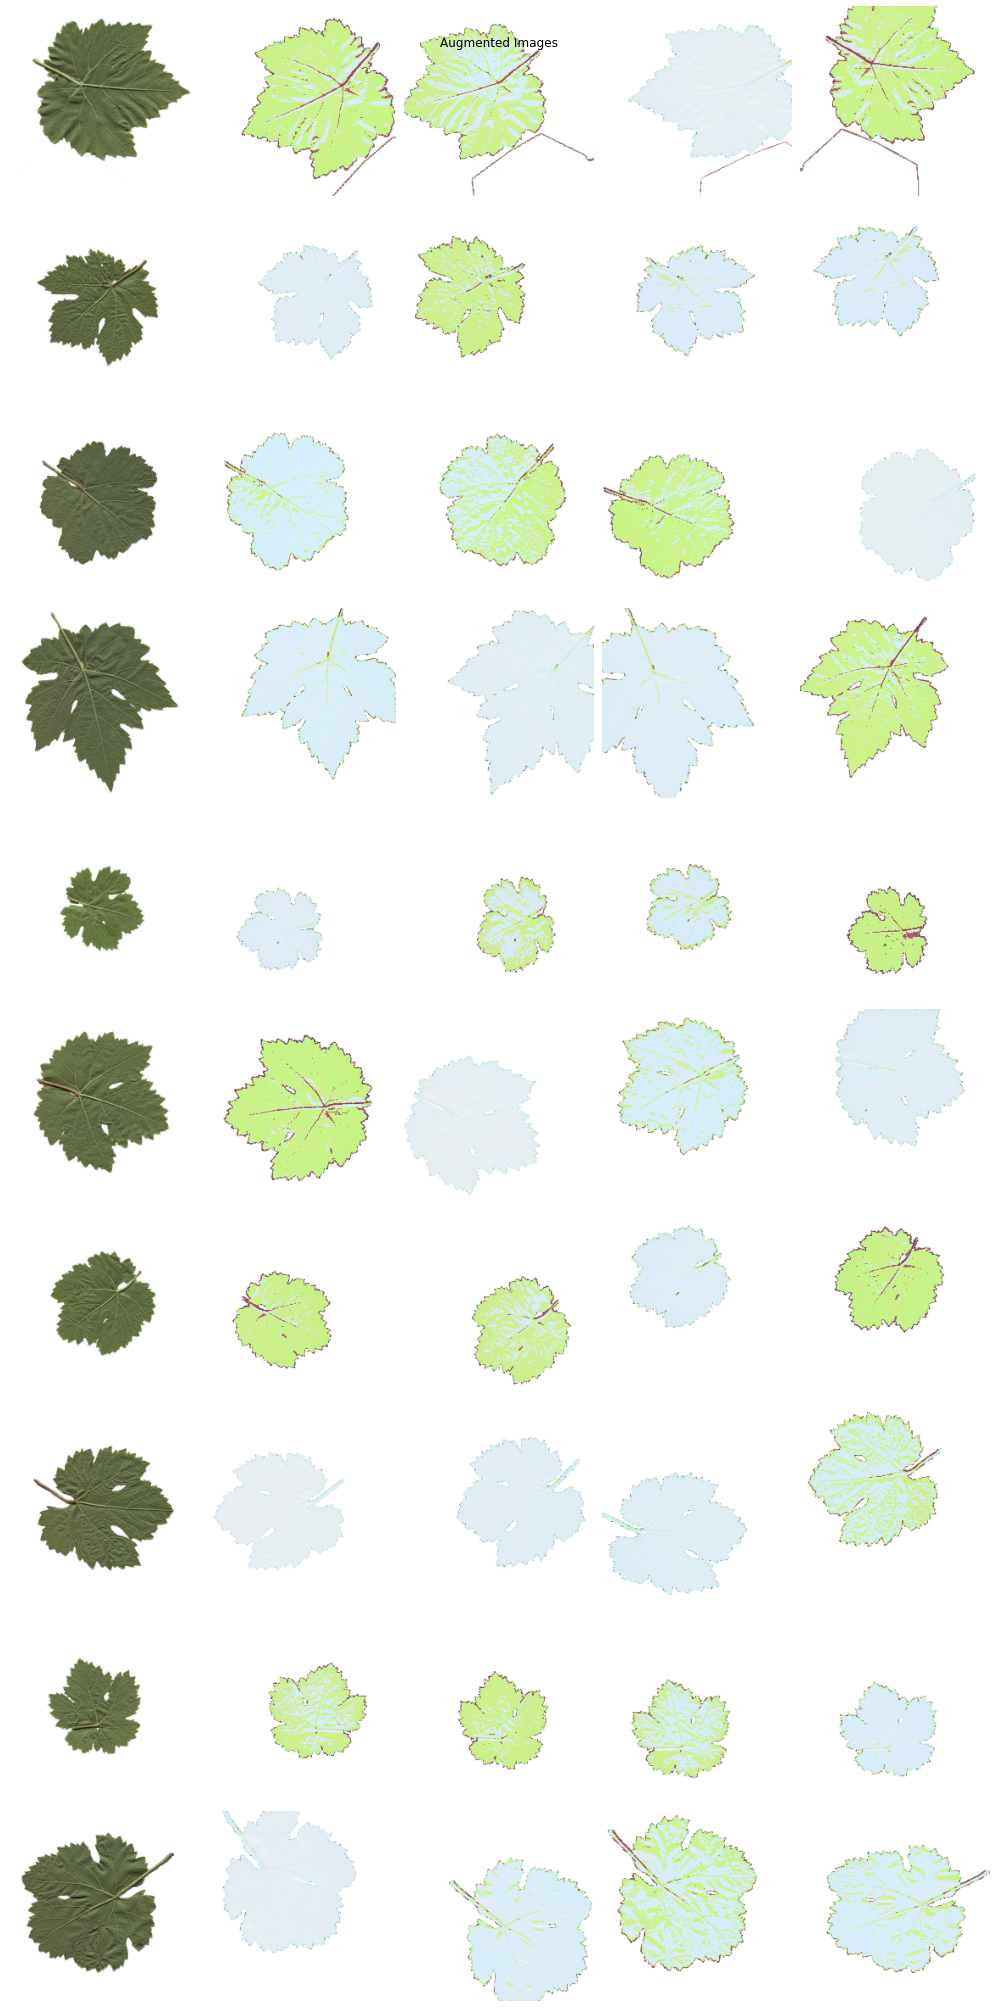

In [ ]:
plot_augimages(np.random.choice(main_df['path'],10), resnet50_datagen)

In [ ]:
resnet50 = ResNet50(include_top = False, input_shape = (227,227,3), weights = 'imagenet')

# training of all the convolution is set to false
for layer in resnet50.layers:
    layer.trainable = False

x = GlobalAveragePooling2D()(resnet50.output)
predictions = Dense(2, activation='softmax')(x)

model_resnet50 = Model(inputs = resnet50.input, outputs = predictions)

94781440/94765736 [==============================] - 1s 0us/step


In [ ]:
model_resnet50.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

In [ ]:
history_resnet50 = model_resnet50.fit(
      train_generator_resnet50,
      validation_data=test_generator_resnet50,
      epochs=20,
      verbose=2)

Epoch 1/20
5/5 - 51s - loss: 0.7756 - accuracy: 0.5071 - val_loss: 0.6350 - val_accuracy: 0.6500 - 51s/epoch - 10s/step
Epoch 2/20
5/5 - 44s - loss: 0.5859 - accuracy: 0.7143 - val_loss: 0.6485 - val_accuracy: 0.6167 - 44s/epoch - 9s/step
Epoch 3/20
5/5 - 44s - loss: 0.5725 - accuracy: 0.7214 - val_loss: 0.5704 - val_accuracy: 0.7500 - 44s/epoch - 9s/step
Epoch 4/20
5/5 - 44s - loss: 0.5244 - accuracy: 0.8071 - val_loss: 0.5486 - val_accuracy: 0.7500 - 44s/epoch - 9s/step
Epoch 5/20
5/5 - 35s - loss: 0.5018 - accuracy: 0.7500 - val_loss: 0.5353 - val_accuracy: 0.7167 - 35s/epoch - 7s/step
Epoch 6/20
5/5 - 34s - loss: 0.4261 - accuracy: 0.8286 - val_loss: 0.4630 - val_accuracy: 0.7833 - 34s/epoch - 7s/step
Epoch 7/20
5/5 - 44s - loss: 0.4567 - accuracy: 0.7857 - val_loss: 0.4583 - val_accuracy: 0.7667 - 44s/epoch - 9s/step
Epoch 8/20
5/5 - 36s - loss: 0.3481 - accuracy: 0.9286 - val_loss: 0.4186 - val_accuracy: 0.8333 - 36s/epoch - 7s/step
Epoch 9/20
5/5 - 44s - loss: 0.3707 - accuracy:

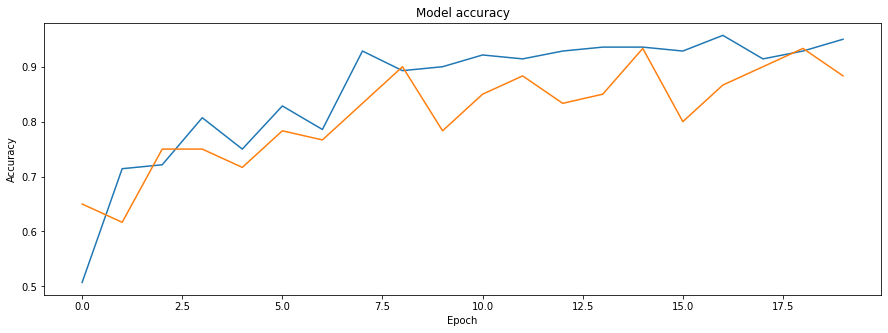

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(history_resnet50.history['accuracy'])
plt.plot(history_resnet50.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

In [ ]:
predictions = model_resnet50.predict(test_generator_resnet50)  # Vector of probabilities
pred_labels = np.argmax(predictions, axis = 1)

In [ ]:
from sklearn.metrics import confusion_matrix
CM = confusion_matrix(test_generator_resnet50.classes, pred_labels)
print('Confusion Matrix')
print(CM)

Confusion Matrix
[[13 18]
 [13 16]]


#### **MobileNetV2**

In [ ]:
from keras.applications.mobilenet_v2 import preprocess_input

In [ ]:
mnv2_datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.10,
    brightness_range=[0.6,1.4],
    channel_shift_range=0.7,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest',
    preprocessing_function=preprocess_input
) 

In [ ]:
train_generator_mnv2 = mnv2_datagen.flow_from_dataframe(
        X_train,  # This is the source directory for training images
        x_col='path',
        y_col='classes',
        target_size=(227, 227),  # All images will be resized to 150x150
        batch_size=32,
        class_mode="categorical",
        shuffle=True,
)

Found 140 validated image filenames belonging to 2 classes.


In [ ]:
test_generator_mnv2 = mnv2_datagen.flow_from_dataframe(
        X_test,  # This is the source directory for training images
        x_col='path',
        y_col='classes',
        target_size=(227, 227),  # All images will be resized to 150x150
        batch_size=32,
        class_mode="categorical",
        shuffle=True,
)

Found 60 validated image filenames belonging to 2 classes.


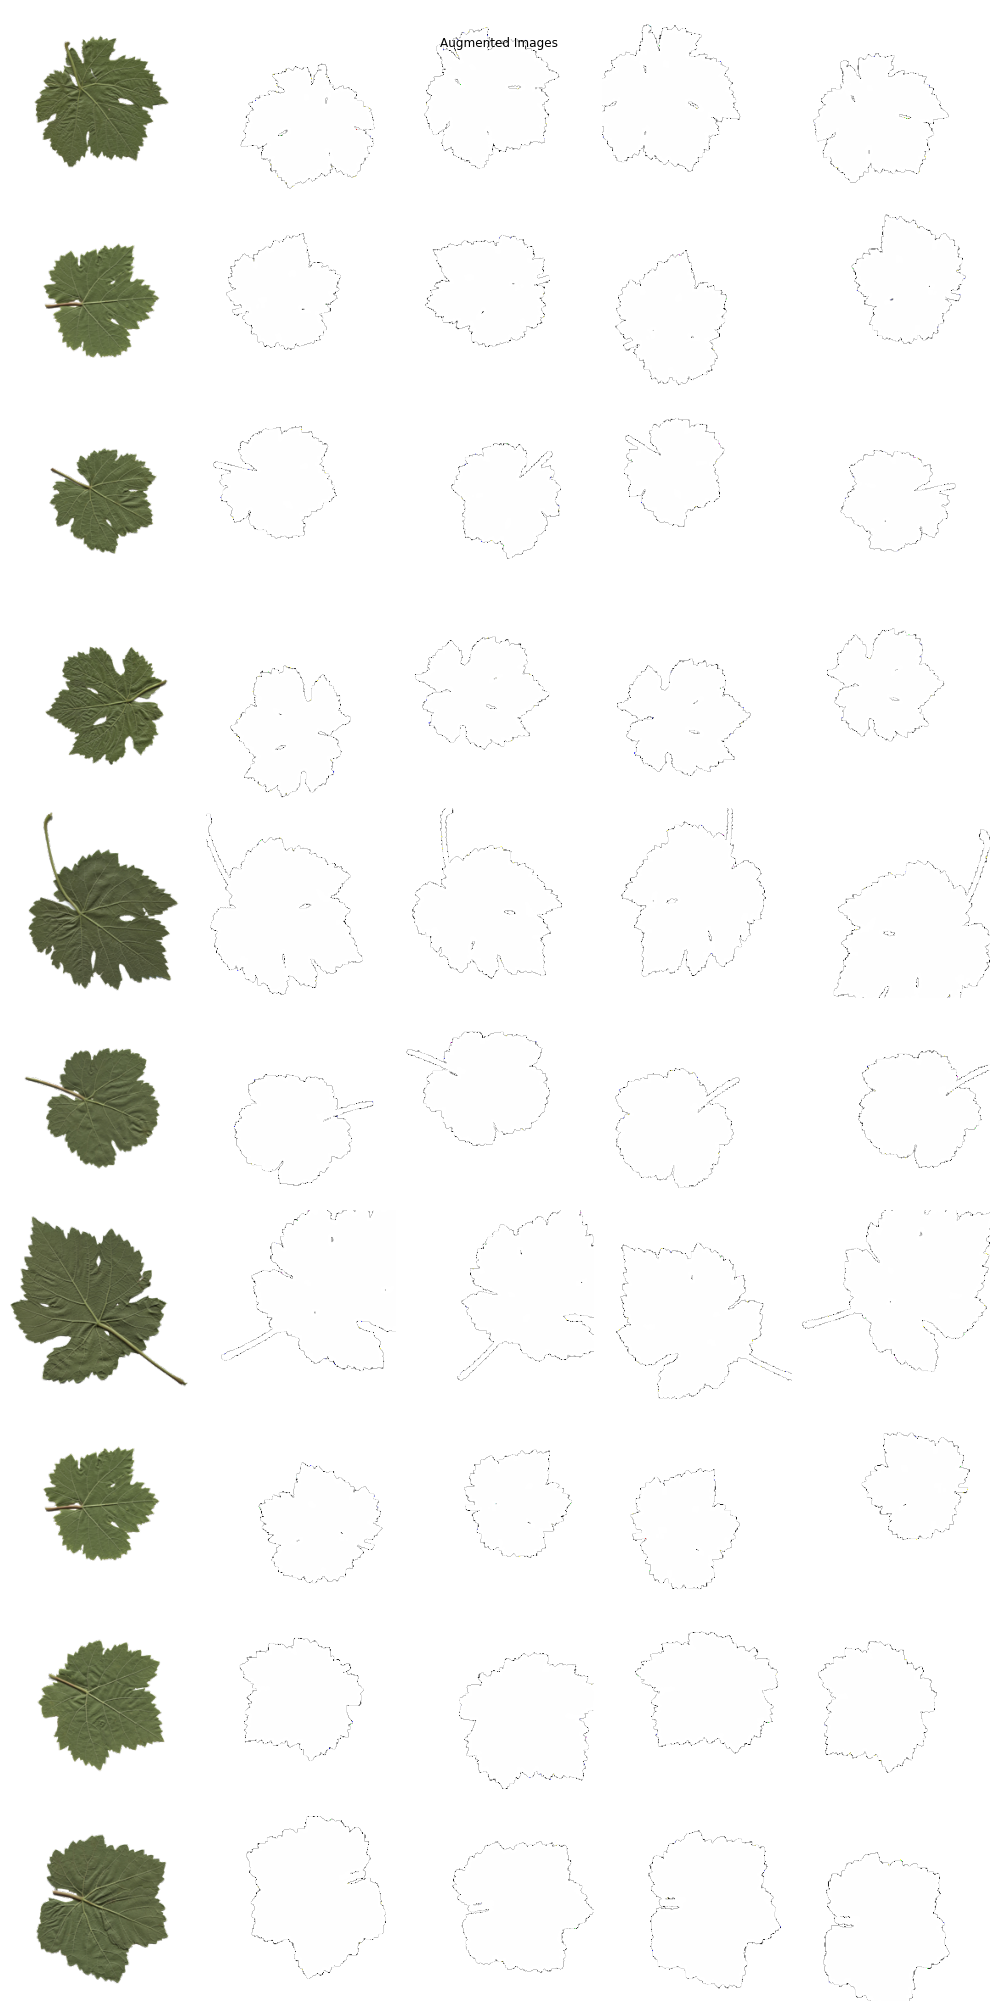

In [ ]:
plot_augimages(np.random.choice(main_df['path'],10), mnv2_datagen)

In [ ]:
mnv2 = MobileNetV2(include_top = False, input_shape = (227,227,3), weights = 'imagenet')

# training of all the convolution is set to false
for layer in mnv2.layers:
    layer.trainable = False

x = GlobalAveragePooling2D()(mnv2.output)
predictions = Dense(2, activation='softmax')(x)

model_mnv2 = Model(inputs = mnv2.input, outputs = predictions)

9420800/9406464 [==============================] - 0s 0us/step


In [ ]:
model_mnv2.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

In [ ]:
history_mnv2 = model_mnv2.fit(
      train_generator_mnv2,
      validation_data=test_generator_vgg,
      epochs=20,
      verbose='auto')

Epoch 1/20
5/5 [==============================] - 16s 3s/step - loss: 0.6692 - accuracy: 0.6286 - val_loss: 0.7020 - val_accuracy: 0.6167
Epoch 2/20
5/5 [==============================] - 13s 3s/step - loss: 0.5397 - accuracy: 0.7786 - val_loss: 0.9112 - val_accuracy: 0.4833
Epoch 3/20
5/5 [==============================] - 12s 3s/step - loss: 0.5079 - accuracy: 0.7857 - val_loss: 0.7736 - val_accuracy: 0.4667
Epoch 4/20
5/5 [==============================] - 12s 2s/step - loss: 0.4515 - accuracy: 0.8571 - val_loss: 0.6970 - val_accuracy: 0.6333
Epoch 5/20
5/5 [==============================] - 9s 2s/step - loss: 0.3757 - accuracy: 0.9000 - val_loss: 0.5647 - val_accuracy: 0.7000
Epoch 6/20
5/5 [==============================] - 9s 2s/step - loss: 0.3596 - accuracy: 0.9000 - val_loss: 0.6874 - val_accuracy: 0.5833
Epoch 7/20
5/5 [==============================] - 9s 2s/step - loss: 0.3206 - accuracy: 0.9071 - val_loss: 0.6368 - val_accuracy: 0.6500
Epoch 8/20
5/5 [=====================

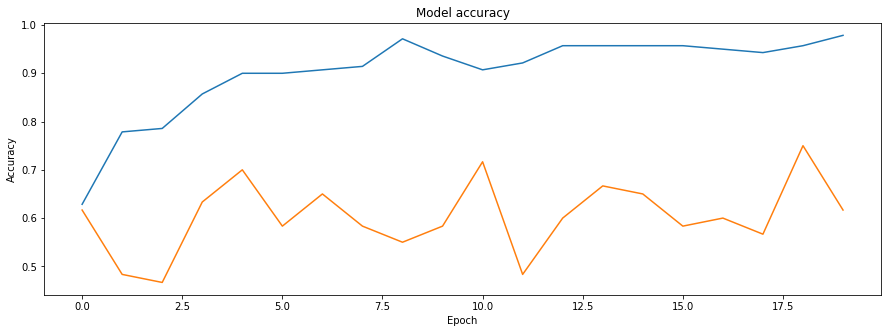

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(history_mnv2.history['accuracy'])
plt.plot(history_mnv2.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

In [ ]:
predictions = model_mnv2.predict(test_generator_mnv2)  # Vector of probabilities
pred_labels = np.argmax(predictions, axis = 1)

In [ ]:
from sklearn.metrics import confusion_matrix
CM = confusion_matrix(test_generator_mnv2.classes, pred_labels)
print('Confusion Matrix')
print(CM)

Confusion Matrix
[[12 19]
 [14 15]]


## Questão 2

O objetivo dessa questão é criar um rastreador de pessoas em vídeos, usando um modelo pré-treinado da YOLO v5.

a) Exiba resultados de detecções em três imagens.

b) Aplique o modelo para detectar pessoas em movimento em um vídeo com a câmera estática. Use o centro das bounding boxes de pessoas detectadas em cada quadro do vídeo para desenhar, sobre a primeira imagem do vídeo, uma curva com a trajetória da(s) pessoa(s). O resultado deve ser semelhante ao da imagem abaixo, onde a curva foi desenhada em vermelho.

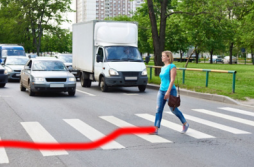

detect: weights=['yolov5s.pt'], source=data/images, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.1-304-g51fb467 Python-3.7.13 torch-1.11.0+cu102 CPU

100% 14.1M/14.1M [00:00<00:00, 139MB/s]

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
image 1/2 /content/yolov5/data/images/bus.jpg: 640x480 4 persons, 1 bus, Done. (0.285s)
image 2/2 /content/yolov5/data/images/zidane.jpg: 384x640 2 persons, 2 ties, Done. (0.217s)
Speed: 2.1ms pre-process, 250.8ms inference, 1.2ms NMS per image at shape (1, 3, 640, 640)
Results saved to runs/detect/exp


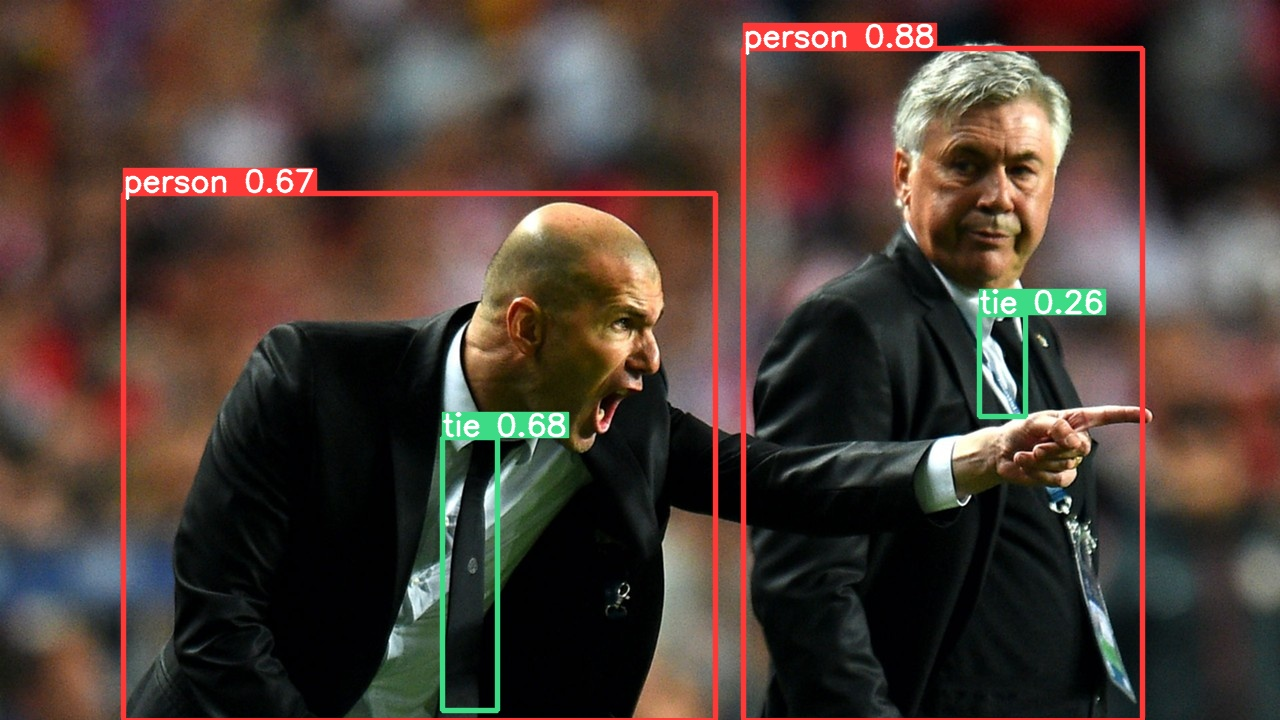

In [ ]:
!python detect.py --weights yolov5s.pt --img 640 --conf 0.25 --source data/images
display.Image(filename='runs/detect/exp/zidane.jpg', width=600)